# Logistic Regression and Multi-layer Feed-forward Neural Network for Digit Recognition

This practical session is designed to implement Logistic Regression (LR) and Multi-layer Feed-forward Neural Network (MFNN) for handwritten digit recognition. [The MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/) is used for training and testing LR and MFNN. 

## Dataset
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of handwritten grayscale digit images. All handwritten digit images have been size-normalized and centered in a fixed size image of 28 x 28 pixels. A grayscale image is nothing but a 2D array of integers between 0 and 255. In the original dataset each pixel of the image is represented by a value between 0 and 255, where 0 is black, 255 is white and anything in between is a different shade of grey. Below is some examples of [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digits:

![MNIST](./mnist-samples.png)


## References
[1] http://yann.lecun.com/exdb/mnist/

[2] https://pjreddie.com/projects/mnist-in-csv/

## Dataset Loading and Visualisation
The following function loads train and test handwritten digit image samples from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [1]:
import matplotlib.pyplot as pl
import numpy as np

In [2]:
def load_dataset(train_dataset='../data/mnist_train.csv', test_dataset='../data/mnist_test.csv'):
    """
    Loads and returns train and test datasets.
    """
    data_train = np.genfromtxt(fname=train_dataset, delimiter=',')
    y_train = data_train[:,0].astype(np.int)
    x_train = data_train[:,1:] / 255.0
    data_test = np.genfromtxt(fname=test_dataset, delimiter=',')
    y_test = data_test[:,0].astype(np.int)
    x_test = data_test[:,1:] / 255.0
    return (x_train, y_train, x_test, y_test)

The following script calls function `load_dataset()` to load train and test datasets. _Be patient as it may take some time to load datasets!_

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()

Each row of `x_train` and `x_test` variables is a 1D vector comprised of 784 (28 * 28) integers and refers to an unpacked handwritten digit image. The following function takes a 1D vector array as input and returns the corresponding 2D representation as image.

In [ ]:
def vector2image(image_vector, image_height=28, image_width=28):
    """
    Returns image representation of the input 1D vector.
    """
    image = np.reshape(image_vector, (image_height, image_width))
    return image

Now you can use `vector2image()` function to convert a 1D feature vector to 2D image for visualisation purposes, e.g.:

In [ ]:
index = 0
image = vector2image(x_train[index])
pl.figure()
pl.imshow(image, cmap='gray')
pl.title('x_train[' + str(index) + '], ' + 'y_train[' + str(index) + '] = ' + str(y_train[index]))
pl.show()

You may also need the following function to convert a 2D grayscale image to 1D vector representation.

In [ ]:
def image2vector(image):
    """
    Returns 1D vector representation of the input 2D image.
    """
    image_height, image_width = image.shape
    image_vector = np.reshape(image, image_height*image_width)
    return image_vector

Thus, `vector2image(image2vector(vector2image(x_train[index])))` must produce exactly same output with that of `vector2image(x_train[index])`, i.e.:

In [ ]:
image = vector2image(image2vector(vector2image(x_train[index])))
pl.figure()
pl.imshow(image, cmap='gray')
pl.title('x_train[' + str(index) + '], ' + 'y_train[' + str(index) + '] = ' + str(y_train[index]))
pl.show()

Now, let's produce an image that is similar to what you see on the very first markdown cell by selecting samples from `x_train` and `y_train`!

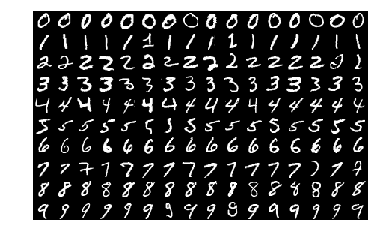

In [33]:
C = 10 # number of digits
R = 16 # images per row
for c in np.arange(C):
    for r in np.arange(R):
        image = vector2image(x_train[y_train==c][r])
        if r == 0:
            image_digits_row = image
        else:
            image_digits_row = np.hstack((image_digits_row, image))
    if c == 0:
        image_digits = image_digits_row
    else:
        image_digits = np.vstack((image_digits, image_digits_row))
pl.figure()
pl.imshow(image_digits, cmap='gray')
pl.axis("off")
# save a copy of this image as png file under ./images folder
pl.imsave('../images/mnist-samples.png', image_digits, cmap='gray') 

We are ready to implement LR classifier for digit recognition.

## Logistic Regression

In [34]:
class LR:
    def __init__(self):
        pass
    
    def parameters(self):
        return self.W
                
    def activation(self, s):
        return 1.0 / (1 + np.exp(-s)) # sigmoid function as activation function
    
    def feedforward(self, X): # output of the logistic regression
        S = np.dot(X, self.W)
        U = self.activation(S)
        return U
        
    def learn(self, X, Y, learning_rate=0.99, delta=1e-6, epoch_max=5000, seed=7):
        self.learning_rate = learning_rate
        self.delta = delta
        self.epoch_max = epoch_max
        self.seed = seed
        np.random.seed(seed)
        X = np.hstack((np.ones((X.shape[0],1)), X))
        d = X.shape[1]
        C =  len(np.unique(Y))
        self.W = np.random.randn(d, C) * 0.01
        N = X.shape[0]
        Y_one_hot = np.zeros((N, C))
        Y_one_hot[np.arange(N), Y] = 1.0
        converged = False
        epoch = 1
        while not converged:
            U = self.feedforward(X)
            E = (U - Y_one_hot)
            D = U * (1-U) * E
            MSE = 1.0 / (2 * N) * np.sum(np.sum(E**2, axis=1))
            if (epoch%100) == 0:
                ACC = self.accuracy(X, Y, True)
                print('epoch = {0}, MSE = {1:.3f}, TRAIN ACC = {2:.3f}'.format(epoch, MSE, ACC))
            W_ = self.W.copy()
            self.W = self.W - self.learning_rate * 1.0/N * np.dot(X.T, D)
            epoch += 1
            if (np.max(np.abs(W_ - self.W)) <= self.delta) or (epoch >=self.epoch_max):
                converged = True        
        
    def classify(self, X, augmented=False):
        if not augmented:
            X = np.hstack((np.ones((X.shape[0],1)), X))
        U = self.feedforward(X)
        L = np.argmax(U, axis=1)            
        return L
    
    def accuracy(self, X, Y, augmented=False):
        N = X.shape[0]
        L = self.classify(X, augmented)
        acc = np.sum(L == Y) / N
        return acc
    
    def confusion_matrix(self, X, Y):
        P = lr.classify(X)
        labels = np.unique(Y)
        CM = np.zeros((len(labels), len(labels)), dtype=np.int)
        for y, p in zip(Y, P):
            CM[y,p] = CM[y,p] + 1
        return CM        

### Train Logistic Regression

In [35]:
lr = LR()
lr.learn(x_train, y_train, 0.99)

epoch = 100, MSE = 0.156, TRAIN ACC = 0.863
epoch = 200, MSE = 0.131, TRAIN ACC = 0.879
epoch = 300, MSE = 0.121, TRAIN ACC = 0.886
epoch = 400, MSE = 0.114, TRAIN ACC = 0.891
epoch = 500, MSE = 0.110, TRAIN ACC = 0.893
epoch = 600, MSE = 0.106, TRAIN ACC = 0.895
epoch = 700, MSE = 0.104, TRAIN ACC = 0.897
epoch = 800, MSE = 0.102, TRAIN ACC = 0.899
epoch = 900, MSE = 0.100, TRAIN ACC = 0.900
epoch = 1000, MSE = 0.098, TRAIN ACC = 0.901
epoch = 1100, MSE = 0.097, TRAIN ACC = 0.903
epoch = 1200, MSE = 0.096, TRAIN ACC = 0.904
epoch = 1300, MSE = 0.095, TRAIN ACC = 0.904
epoch = 1400, MSE = 0.094, TRAIN ACC = 0.905
epoch = 1500, MSE = 0.093, TRAIN ACC = 0.906
epoch = 1600, MSE = 0.092, TRAIN ACC = 0.906
epoch = 1700, MSE = 0.092, TRAIN ACC = 0.907
epoch = 1800, MSE = 0.091, TRAIN ACC = 0.908
epoch = 1900, MSE = 0.090, TRAIN ACC = 0.908
epoch = 2000, MSE = 0.090, TRAIN ACC = 0.909
epoch = 2100, MSE = 0.089, TRAIN ACC = 0.909
epoch = 2200, MSE = 0.089, TRAIN ACC = 0.910
epoch = 2300, MSE =

### Test Accuracy of the Trained Logistic Regression

In [36]:
print('TEST ACC = {0:.3f}'.format(lr.accuracy(x_test, y_test)))

TEST ACC = 0.918


### Sample Digit Classification Results

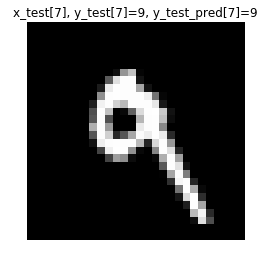

In [39]:
index = 7
image_test = vector2image(x_test[index])
image_test_label = y_test[index]
image_test_label_predicted = lr.classify(x_test[index][np.newaxis, :])[0]
pl.figure()
pl.imshow(image_test, cmap='gray')
pl.axis('off')
pl.title('x_test[{0}], y_test[{0}]={1}, y_test_pred[{0}]={2}'.format(index, image_test_label, image_test_label_predicted))
pl.show()

### Confusion Matrix

In [40]:
print(lr.confusion_matrix(x_test, y_test))

[[ 963    0    0    2    0    2    8    1    4    0]
 [   0 1104    3    4    0    2    5    2   15    0]
 [   9    1  931   10   11    3   12   15   36    4]
 [   3    0   23  921    2   21    4    9   17   10]
 [   3    2    6    0  908    0   11    2   10   40]
 [  13    3    4   34   12  759   19    8   32    8]
 [  11    3    3    1    7   13  913    1    6    0]
 [   4   10   25    5    7    1    1  946    2   27]
 [  12    5    9   16   14   24   11   15  863    5]
 [  11    6    2   14   54    9    0   25   15  873]]
